# Predicing Healthcare related infections
### Capstone 2
__Pre-processing and training__

Data science process: <br>
Problem identification > Data wrangling > EDA > __Pre-processing and training__ > Modeling >
Documentation

This is a continuation from prior work, for the complete workflow see:
https://github.com/rejexx/Predicting_infection/

#### Significance:

"At any given time, about 1 in 25 inpatients have an infection related to hospital care. These infections lead to tens of thousands of deaths and cost the U.S. health care system billions of dollars each year." - https://health.gov/our-work/health-care-quality/health-care-associated-infections

__Plan__

In this document I do some feature engineering and test several different machine learning algorithms, split into train and test and hone in on a final model (for now).

In [45]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import plotly.express as px  #Interactive plots
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus #Viz for decision trees
from io import StringIO  #Viz for decision trees
from IPython.display import Image #Viz for decision trees

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics, tree, linear_model
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [46]:
#Import data
HAI_tidy = pd.read_csv('.\data\HAI_tidy_Encoded.csv')
HAI_tidy.shape

(3096, 57)

In [47]:
#Drop anything with NA in the predictor col
HAI_tidy.dropna(subset=['HAI_5_SIR_Score'], inplace=True)
#HAI_tidy.info()

In [48]:
#Drop info cols
HAI_tidy.drop(['ZIP Code'], axis="columns", inplace=True)
HAI_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1715 entries, 0 to 3095
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   HAI_1_DOPC                           1712 non-null   float64
 1   HAI_1_ELIGCASES                      1712 non-null   float64
 2   HAI_1_NUMERATOR                      1712 non-null   float64
 3   HAI_1_SIR_Score                      1675 non-null   float64
 4   HAI_2_DOPC                           1712 non-null   float64
 5   HAI_2_ELIGCASES                      1712 non-null   float64
 6   HAI_2_NUMERATOR                      1712 non-null   float64
 7   HAI_2_SIR_Score                      1689 non-null   float64
 8   HAI_3_DOPC                           1704 non-null   float64
 9   HAI_3_ELIGCASES                      1704 non-null   float64
 10  HAI_3_NUMERATOR                      1704 non-null   float64
 11  HAI_3_SIR_Score               

In [49]:
#Feature engineering, add some features that may help.
HAI_tidy['HAI_1_hoursPerCase'] = HAI_tidy.HAI_1_DOPC / HAI_tidy.HAI_1_ELIGCASES  #Patient hours / observed cases per hospital
HAI_tidy['HAI_2_hoursPerCase'] = HAI_tidy.HAI_2_DOPC / HAI_tidy.HAI_2_ELIGCASES
HAI_tidy['HAI_3_hoursPerCase'] = HAI_tidy.HAI_3_DOPC / HAI_tidy.HAI_3_ELIGCASES
HAI_tidy['HAI_4_hoursPerCase'] = HAI_tidy.HAI_4_DOPC / HAI_tidy.HAI_4_ELIGCASES
HAI_tidy['HAI_6_hoursPerCase'] = HAI_tidy.HAI_6_DOPC / HAI_tidy.HAI_6_ELIGCASES

HAI_tidy.replace(np.inf, np.nan, inplace=True) #Remove due to divide by 0

In [50]:
#Drop upper and lower limts from HAI data, and other columns that are highly internally correlateda
HAI_baseLine = HAI_tidy[HAI_tidy.columns.drop(HAI_tidy.filter(regex='CILOWER|CIUPPER|.+STAR').columns )]

In [51]:
HAI_baseLine.columns  #Start with these, bring others back if needed.

Index(['HAI_1_DOPC', 'HAI_1_ELIGCASES', 'HAI_1_NUMERATOR', 'HAI_1_SIR_Score',
       'HAI_2_DOPC', 'HAI_2_ELIGCASES', 'HAI_2_NUMERATOR', 'HAI_2_SIR_Score',
       'HAI_3_DOPC', 'HAI_3_ELIGCASES', 'HAI_3_NUMERATOR', 'HAI_3_SIR_Score',
       'HAI_4_DOPC', 'HAI_4_ELIGCASES', 'HAI_4_NUMERATOR', 'HAI_4_SIR_Score',
       'HAI_5_DOPC', 'HAI_5_ELIGCASES', 'HAI_5_NUMERATOR', 'HAI_5_SIR_Score',
       'HAI_6_DOPC', 'HAI_6_ELIGCASES', 'HAI_6_NUMERATOR', 'HAI_6_SIR_Score',
       'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE',
       'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
       'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE',
       'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
       'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'SEP_1', 'SEP_SH_3HR',
       'SEP_SH_6HR', 'SEV_SEP_3HR', 'SEV_SEP_6HR',
       'HAI_1_SIR_ComparedToNational_encode',
       'HAI_2_SIR_ComparedToNational_encode',
       'HAI_3_SIR_ComparedToNational_encode',
       'HAI_4_SIR_ComparedToNatio

## Train test split and choose X and y

Now that the features are set, its time to set x and y and split into train-test.
I'm trying to predict the HAI_5_SIR_SCORE which is a normalized score the MRSA infections, computed based off predicted infections / observed infections encoded into <code> HAI_5_NUMERATOR / HAI_5_ELIGCASES </code>.

To make the prediction fair, I'll drop ALL HAI_5 columns, not just the SIR score, since the SIR score is a transformation from the others. I.e. the DOPC, ELIGCASES, NUMERATOR and SIR_Score for HAI_5.  (patient hours, observed cases, predicted cases and normalized score respectively).

In [52]:
#Since most HAI_5 data is highly related, it's 'cheating' to give any of it to the model, drop all columns from HAI_5
#  EXCEPT the DOPC which is related but not actually part of the SIR score.
#May need to add the compared to national back if needed.
X = HAI_baseLine[HAI_baseLine.columns.drop(['HAI_5_ELIGCASES', 'HAI_5_NUMERATOR', 'HAI_5_SIR_Score', 'HAI_5_SIR_ComparedToNational_encode'])]
y_full = HAI_baseLine[['HAI_5_ELIGCASES', 'HAI_5_NUMERATOR', 'HAI_5_SIR_Score', 'HAI_5_SIR_ComparedToNational_encode']]
#I'm testing multiple Y values, and will assign a single one after the train test split for each run.

In [53]:
X_train_nans, X_test_nans, y_train_full, y_test_full = train_test_split(X, 
                                                    y_full, test_size=0.3, 
                                                    random_state=47)
#Set Y to ONLY the SIR score, which is what I'm trying to predict
y_train = y_train_full.HAI_5_SIR_Score
y_test = y_test_full.HAI_5_SIR_Score

print(X_train_nans.columns) #removed target

Index(['HAI_1_DOPC', 'HAI_1_ELIGCASES', 'HAI_1_NUMERATOR', 'HAI_1_SIR_Score',
       'HAI_2_DOPC', 'HAI_2_ELIGCASES', 'HAI_2_NUMERATOR', 'HAI_2_SIR_Score',
       'HAI_3_DOPC', 'HAI_3_ELIGCASES', 'HAI_3_NUMERATOR', 'HAI_3_SIR_Score',
       'HAI_4_DOPC', 'HAI_4_ELIGCASES', 'HAI_4_NUMERATOR', 'HAI_4_SIR_Score',
       'HAI_5_DOPC', 'HAI_6_DOPC', 'HAI_6_ELIGCASES', 'HAI_6_NUMERATOR',
       'HAI_6_SIR_Score', 'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE',
       'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
       'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE',
       'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
       'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'SEP_1', 'SEP_SH_3HR',
       'SEP_SH_6HR', 'SEV_SEP_3HR', 'SEV_SEP_6HR',
       'HAI_1_SIR_ComparedToNational_encode',
       'HAI_2_SIR_ComparedToNational_encode',
       'HAI_3_SIR_ComparedToNational_encode',
       'HAI_4_SIR_ComparedToNational_encode',
       'HAI_6_SIR_ComparedToNational_encode', 'HAI_

In [54]:
#Impute with mean
X_train_defaults_mean = X_train_nans.mean()
X_train = X_train_nans.fillna(X_train_defaults_mean)
X_test = X_test_nans.fillna(X_train_defaults_mean)  #Since we 'don't know' about this data, I'm filling it with the train mean

## Decision tree

In [55]:
# Declare a variable called entr_model and use tree.DecisionTreeClassifier. 
treeReg = tree.DecisionTreeRegressor(min_samples_leaf=2)

#Fit and predict
treeReg.fit(X_train, y_train)
y_pred = treeReg.predict(X_test)

#Convert to series
y_pred = pd.Series(y_pred)

r2 -0.9575055756294513


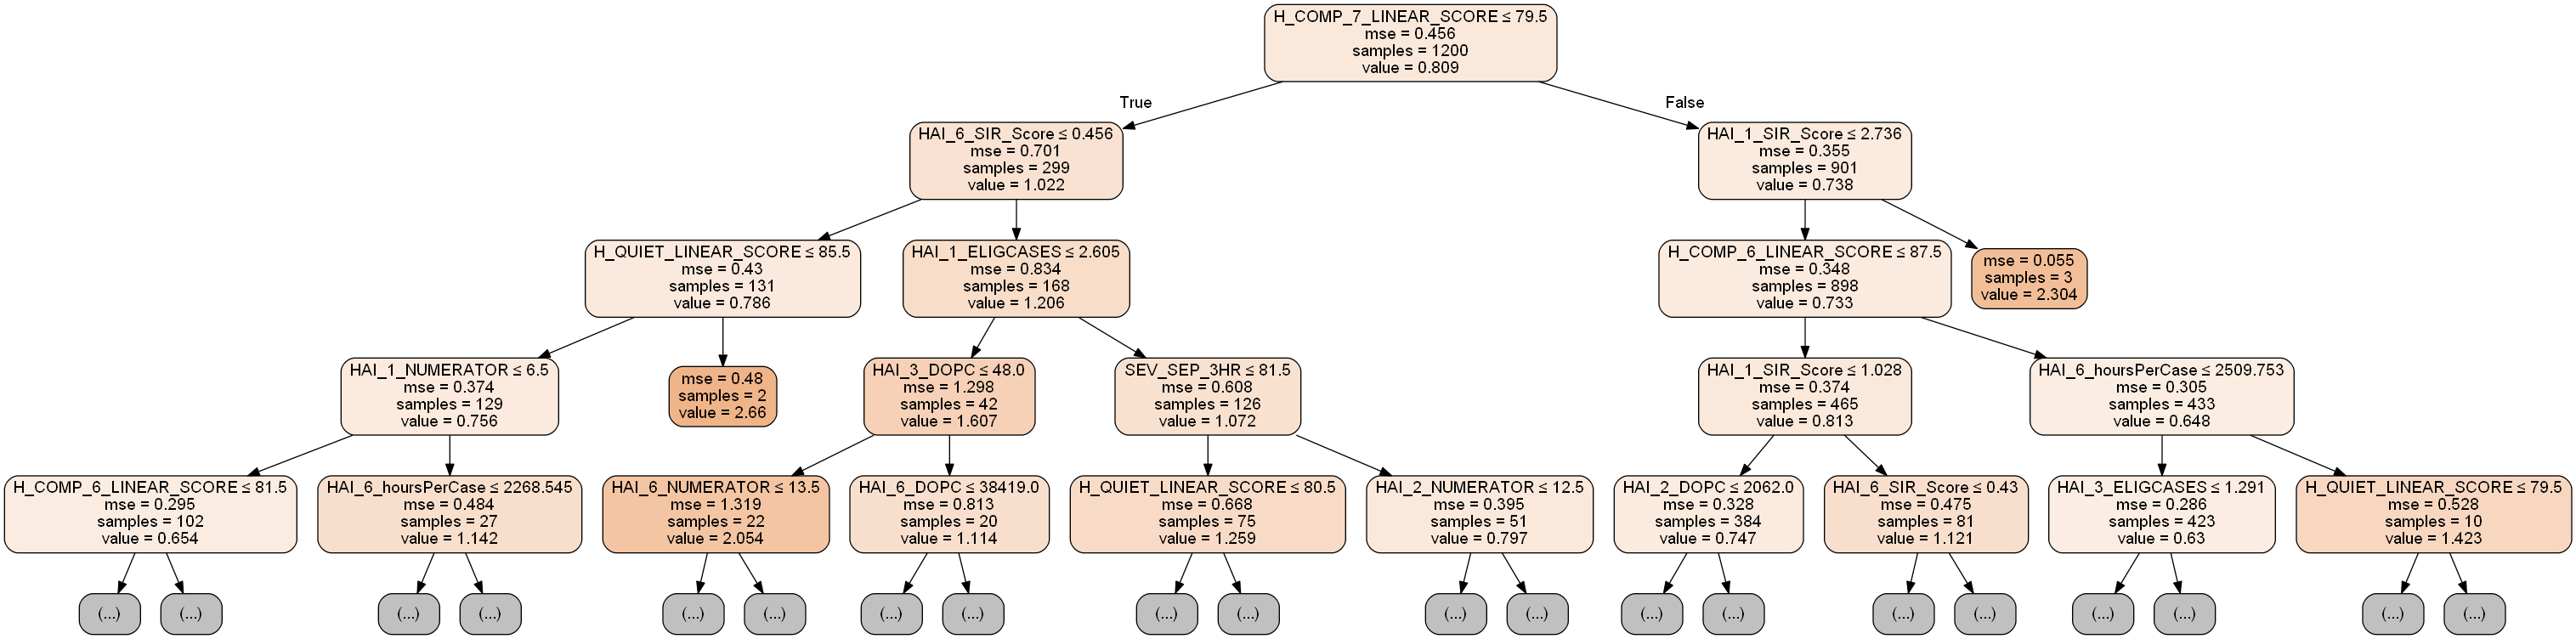

In [56]:
# function to display tree
def treeViz(model, max_depth=4):
    # Now we want to visualize the tree
    dot_data = StringIO()

    # We can do so with export_graphviz
    tree.export_graphviz(model, out_file=dot_data, max_depth=max_depth, 
                    filled=True, rounded=True,
                    special_characters=True, feature_names=X_train.columns) 

    # Alternatively for class_names use entr_model.classes_
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    
    return graph

graph = treeViz(treeReg, max_depth=4)
print('r2', metrics.r2_score(y_test,y_pred))
Image(graph.create_png())


### Random Forest

In [57]:
RFreg = RandomForestRegressor(min_samples_leaf=5, random_state=42)
RFreg.fit(X_train, y_train)

y_pred = RFreg.predict(X_test)

r2: 0.011796319686749546


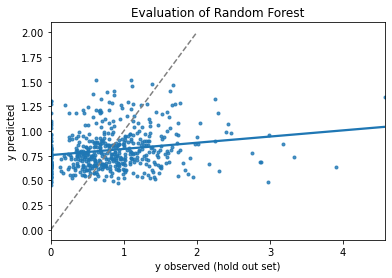

In [58]:
#modelResults(y_test, y_pred)
print('r2:', metrics.r2_score(y_test,y_pred))
#px.scatter(x=y_test, y=y_pred)
sns.regplot(x=y_test, y=y_pred, marker='.', ci=None)
plt.title("Evaluation of Random Forest")
plt.xlabel('y observed (hold out set)')
plt.ylabel('y predicted')
plt.plot([0,1,2], [0,1,2], linestyle='dashed', color='gray'); #ideal line of 'perfect' fit

## Linear regression

Compute a mean model to compare score with.

In [59]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

0.8090583333333325

In [60]:
#Fit the dummy regressor on the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
y_tr_pred = dumb_reg.predict(X_train)
y_te_pred = train_mean * np.ones(len(y_test))

Check the "mean" model metrics __'dummy' mean model__

In [61]:
def printScore(y_train, y_test, y_tr_pred, y_te_pred):
    median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
    print("median_r2, train, test", median_r2)

    median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
    print("median MAE, train, test: ", median_mae)

    median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
    print("median MSE,  train, test", median_mse)
    return None

In [62]:
printScore(y_train, y_test, y_tr_pred, y_te_pred)

median_r2, train, test (0.0, -0.0010541157440056015)
median MAE, train, test:  (0.49731080555555557, 0.45229762135922325)
median MSE,  train, test (0.4560547265972222, 0.38023078641248653)


Simplistic regression with imputation, __Actual data__

In [63]:
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)
#X_tr_scaled[:5,:5]

In [64]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [65]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)


printScore(y_train, y_test, y_tr_pred, y_te_pred)

median_r2, train, test (0.1176980420239867, -0.029978082814763107)
median MAE, train, test:  (0.4720571177321282, 0.4607903955319469)
median MSE,  train, test (0.40237797822094457, 0.3912169884294566)


## Check in and new direction

Attempting to predict the HAI_5_SIR score appears pointless using these basic methods.  With no tuning, the results are essentially the same as using the mean, with an r2 of near 0.  

Since the SIR score is computed as predicted / observed cases, and those values had better correlation between other independent variables, perhaps I can predict both of those, then compute a new SIR myself instead?

### Computing Numerator

Try random forest and ridge regression (these showed best results in testing).

In [66]:
#set Y to be numerator feature
y_train = y_train_full.HAI_5_NUMERATOR
y_test = y_test_full.HAI_5_NUMERATOR
X_train = X_train_nans
X_test = X_test_nans

847     5.0
45      7.0
2156    1.0
652     1.0
125     3.0
Name: HAI_5_NUMERATOR, dtype: float64

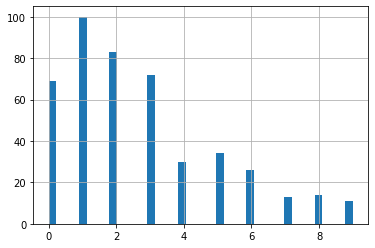

In [67]:
#these data have been rounded to integers :-(
y_test[y_test < 10].hist(bins=40)
y_test.head()

#### Random forest on numerator

In [68]:
RFreg = RandomForestRegressor(random_state=42)

grid_params_rf = {'simpleimputer__strategy': ['mean', 'median'], 
              'randomforestregressor__min_samples_split': [3,5,8],
                  'randomforestregressor__n_estimators': [20,100,200]
              }
rfPipe = make_pipeline(SimpleImputer(), RFreg)

rfGrid = GridSearchCV(rfPipe, param_grid=grid_params_rf, cv=5, n_jobs=-1)


In [69]:

rfGrid.fit(X_train, y_train)

y_tr_pred_numerator_rf = rfGrid.predict(X_train)
y_te_pred_numerator_rf = rfGrid.predict(X_test)

median_r2, train, test (0.9476465858613466, 0.7242389241273772)
median MAE, train, test:  (0.8395287104562105, 1.9902106115567284)
median MSE,  train, test (1.7525514796570754, 10.019169023056692)


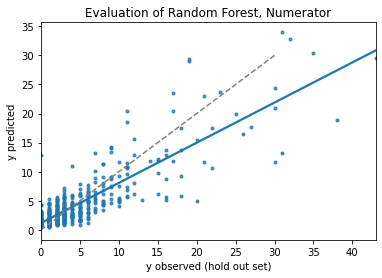

In [70]:
#modelResults(y_test, y_pred)
printScore(y_train, y_test, y_tr_pred_numerator_rf, y_te_pred_numerator_rf)
#px.scatter(x=y_test, y=y_pred)
sns.regplot(x=y_test, y=y_te_pred_numerator_rf, marker='.', ci=None)
plt.title("Evaluation of Random Forest, Numerator")
plt.xlabel('y observed (hold out set)')
plt.ylabel('y predicted')
plt.plot([0,1,30], [0,1,30], linestyle='dashed', color='gray'); #ideal line of 'perfect' fit

In [71]:
#Can I improve by rounding?
printScore(y_train, y_test, y_tr_pred.round(), y_te_pred.round())
#Not really

median_r2, train, test (-0.3423289938283036, -0.35420216587916364)
median MAE, train, test:  (3.7066666666666666, 3.8660194174757283)
median MSE,  train, test (44.935, 49.20194174757282)


In [72]:
rfGrid.best_params_

{'randomforestregressor__min_samples_split': 5,
 'randomforestregressor__n_estimators': 100,
 'simpleimputer__strategy': 'mean'}

Wow, that looks much more workable! It also looks like random forest is over fitting.

### Compare with ridge regression

In [73]:
#Mean or median impute?
#Reset the X values to include NaNs, test mean vs. median imputeing
X_train = X_train_nans
#X_train['y_tr_pred_EligCases'] = y_tr_pred_EligCases #"What if we computed EligCases first then fed to the model?"
X_test = X_test_nans
#X_test['y_te_pred_EligCases'] = y_te_pred_EligCases

RR_pipe = make_pipeline(
    SimpleImputer(), #part of grid searc
    StandardScaler(),
    SelectKBest(f_regression),
    linear_model.RidgeCV(cv=5)
)
#Ridge regression params?

grid_params = {'simpleimputer__strategy': ['mean', 'median'], 
              'selectkbest__k': [1,5,10,15,30,45],
              }

rrGrid = GridSearchCV(RR_pipe, param_grid=grid_params, cv=2, n_jobs=-1)


In [74]:
rrGrid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001DE69D218C8>)),
                                       ('ridgecv',
                                        RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                                cv=5))]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 5, 10, 15, 30, 45],
                         'simpleimputer__strategy': ['mean', 'median']})

median_r2, train, test (0.7192285014574002, 0.7186713440599094)
median MAE, train, test:  (2.016190874722428, 2.0357498419095976)
median MSE,  train, test (9.398938222312944, 10.221454735675277)


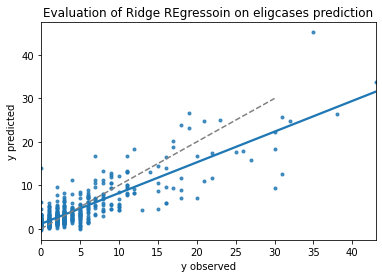

In [75]:
y_tr_pred_numerator = rrGrid.predict(X_train)
y_te_pred_numerator = rrGrid.predict(X_test)

printScore(y_train, y_test, y_tr_pred_numerator, y_te_pred_numerator)

sns.regplot(x=y_test, y=y_te_pred_numerator, marker='.', ci=None)
plt.title("Evaluation of Ridge REgressoin on eligcases prediction")
plt.xlabel('y observed')
plt.ylabel('y predicted')
plt.plot([0,1,30], [0,1,30], linestyle='dashed', color='gray');

Looks like the regression is doing a better job of explaining the outlier values, while Random forest is overfitting on the smaller values.  I like the way regression is handling this better

In [76]:
rrGrid.best_params_

{'selectkbest__k': 15, 'simpleimputer__strategy': 'median'}

__Summary__ for numerator - it appears the random forest has the lowest MAE score, compared with ridge regressor.  It's not by much, but it will work.

### Ridge regression on EligCases (observed cases)

Compute prediction for "numerator" and for SIR_score using the ridge regressor.

In [77]:
y_full.columns #reminder of what the columns are named

Index(['HAI_5_ELIGCASES', 'HAI_5_NUMERATOR', 'HAI_5_SIR_Score',
       'HAI_5_SIR_ComparedToNational_encode'],
      dtype='object')

In [78]:
#Try to predict another HAI_5 feature, which is used to compute the SIR score
y_train = y_train_full.HAI_5_ELIGCASES
y_test = y_test_full.HAI_5_ELIGCASES

#This has a good score, so I haven't employed a grid search here.
ridgeCV = linear_model.RidgeCV(cv=5).fit(X_tr_scaled, y_train)

median_r2, train, test (0.9508670827144562, 0.9402410685870299)
median MAE, train, test:  (0.8260420700998843, 0.8683176562556779)
median MSE,  train, test (1.6901272188533096, 1.8071780685704706)


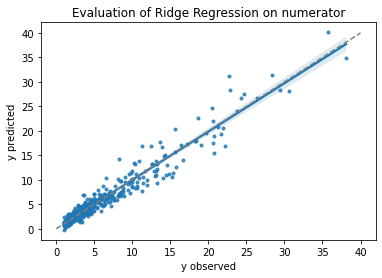

In [79]:
y_tr_pred_EligCases = ridgeCV.predict(X_tr_scaled)
y_te_pred_EligCases = ridgeCV.predict(X_te_scaled)

printScore(y_train, y_test, y_tr_pred_EligCases, y_te_pred_EligCases)

sns.regplot(x=y_test, y=y_te_pred_EligCases, marker='.', x_ci=None)
plt.title("Evaluation of Ridge Regression on numerator")
plt.xlabel('y observed')
plt.ylabel('y predicted')
plt.plot([0,1,40], [0,1,40], linestyle='dashed', color='gray');

### Combine the final predictions to create a SIR prediction

median_r2, train, test (0.7092955363540956, -0.7325782184158427)
median MAE, train, test:  (0.25527050289438125, 0.5166530656334365)
median MSE,  train, test (0.13257714468862503, 0.6580858798225719)


Text(0, 0.5, 'y predicted')

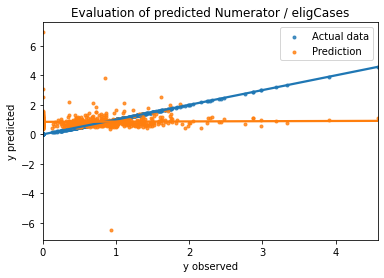

In [80]:
SIR_predict_train = y_tr_pred_numerator_rf / y_tr_pred_EligCases
SIR_predict_test = y_te_pred_numerator_rf / y_te_pred_EligCases

printScore(y_train_full.HAI_5_SIR_Score,y_test_full.HAI_5_SIR_Score,SIR_predict_train, SIR_predict_test)

sns.regplot(x = y_test_full.HAI_5_SIR_Score, y = (y_test_full.HAI_5_NUMERATOR / y_test_full.HAI_5_ELIGCASES)
            , marker='.', ci=False, label="Actual data")

sns.regplot(x=y_test_full.HAI_5_SIR_Score, y=y_te_pred_numerator_rf / y_te_pred_EligCases, marker='.', ci=False, label="Prediction")

plt.legend()
plt.title("Evaluation of predicted Numerator / eligCases")
plt.xlabel('y observed')
plt.ylabel('y predicted')


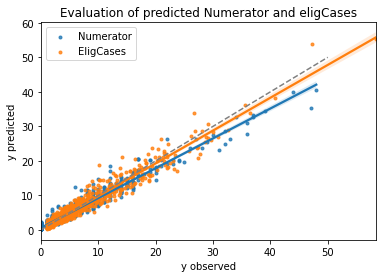

In [81]:
sns.regplot(y = y_tr_pred_numerator_rf, x = y_train_full.HAI_5_NUMERATOR, marker='.', label="Numerator")
sns.regplot(y = y_tr_pred_EligCases, x = y_train_full.HAI_5_ELIGCASES, marker='.', label="EligCases")

plt.legend()
plt.title("Evaluation of predicted Numerator and eligCases")
plt.xlabel('y observed')
plt.ylabel('y predicted')
plt.plot([0,1,50], [0,1,50], linestyle='dashed', color='gray', label="Actual data");

## Summary

1. Trying to predict the SIR score (normalized score of MRSA infections per hospital) is difficult and has poor results
2. However predicting the number of observed cases ("ELIGCASES") is very doable (0.94 r2)
3. Predicting the 'numerator' is doable, but less accurate than the eligCases.
4. Dividing the above to to create a SIR score... doesn't give better results than direct prediction

This is because the normalized SIR score is very sensitive since it's dividing two values to get a final one.  Despite lack of getting a meaningful SIR score, I think getting a good value for "Observed" cases is helpful.  It essentially gives a prediction for how many patients a hospital will expect based off other hospital information.

### Lessons learned

I found that the metric I was looking for had a very poor fit almost regardless of the algorithm.  This wasn't a surprise after doing EDA.  The attempted solution was to compute two different features which are used to compute that algorithm, and were much easier to predict.

However, predicting the numerator was still hard. This value is rounded and based off other data I don't necessarily have, such as time series for past performance.  